# Introduction

This is a project for the Kaggle competition: https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching

This project:

- Applies transformer models on patent phrase similarity classification. 
- Fine-tunes RoBERTa and BERT-for-Patent for more accurate inferences. 
- Performs error analysis to explore the strength and weakness of each model. 
- Uses Ensemble techniques to combine models and attain higher accuracy.

# Preparing Environment

We need to complete the following tasks before analyzing our data.

1.   Install and load necessary packages, such as Kaggle, transformers...
2.   Check the running environment.
3.   Log in the Kaggle API 
4.   Create a file path.
5.   Download datasets and then unzip them into csv format.
6.   Finally, check if our datasets are available or not.






In [ ]:
!pip install -q kaggle
!pip install -q datasets transformers[sentencepiece]
!pip install -q fastai

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
creds = '{"username":"dongdonglu","key":"a15c9f012569587f3892a56683059d9a"}'

In [ ]:
from fastai.imports import *

In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [ ]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()

In [ ]:
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)

cred_path.chmod(0o600)

In [ ]:
path = Path('us-patent-phrase-to-phrase-matching')

In [ ]:
path.exists()

True

In [ ]:
if not iskaggle and not path.exists():
  import zipfile, kaggle
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

In [ ]:
ls {path}

sample_submission.csv  test.csv  train.csv


# EDA

We first load our dataset to see what it looks like.

In [ ]:
import pandas as pd

df = pd.read_csv(path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


Our dataset has 36473 rows, 733 unique anchors, 106 contexts, and 29340 targets. Certain anchors appear very often, for instance the  "component composite coating" appears 152 times.


In [ ]:
df.describe(include='object')
# every object is respect to id, anchor, target and context.

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


Then we went further to check if the scores, context are balanced or not. It seems that the scores are balanced, but the context is little bit skewed toward lower scores.

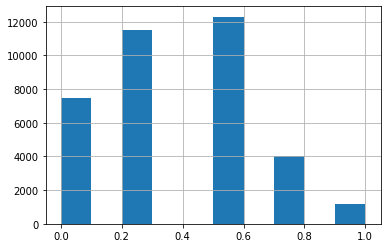

In [ ]:
df.score.hist()

The most frequently appearing context is "B" and the least frequently appearing context is "D". The sub-contexts are even more unbalanced, this might be due to the fact that more patents are granted in certain areas than than others.

In [ ]:
df['section'] = df.context.str[0] # get the initial letter for the context
df.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

In [ ]:
df.context.value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

Lastly, we check what the instances with the highest and lowest score look like. Notice that "abatement" has similarity score 1 with "abating" in context "F", however it only has similarity score 0 with "rent abatement" in context A. This shows that context is very important in determining the similarity between two words, rather than the simple word-spellings of phrases.

In [ ]:
df[df['score'] == 1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


In [ ]:
df[df['score'] == 0]

,id,anchor,target,context,score,section
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.0,A
14,9001756895ec8ca1,abatement,pollution certificate,A47,0.0,A
15,cc96541d4987b399,abatement,rent abatement,A47,0.0,A
18,1222e36d9a94c2a4,abatement,stone abutments,A47,0.0,A
19,a8c9e9f37d4d836a,abatement,tax abatement,A47,0.0,A
...,...,...,...,...,...,...
36447,c7e11e374c52eec4,wood article,article spinner,B44,0.0,B
36448,c93eebfb43880214,wood article,article spinning,B44,0.0,B
36449,c997d1dc4fbcd02b,wood article,article tracking system,B44,0.0,B
36457,1d5bb300f80bc6db,wood article,plastic articles,B44,0.0,B


# Data Preprocessing

In [ ]:
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer

Here we provide a list of models, which will be used in the following evaluations. Why do I pick those models? The answer is straightward, because I see other people are getting good results on Kaggle by using these models.

In [ ]:
model_dbt = 'microsoft/deberta-v3-large' 
model_bfp = 'anferico/bert-for-patents'

Write a function to automate the processing of getting the tokenizer corresponding to the model.

In [ ]:
def tokz(model):
  return AutoTokenizer.from_pretrained(model)

To conveniently convert the problem into a classification problem, we need to merge all the information for each row into a long string. The easiest way to do this is concatenate all the column values with the tokenizer's separation token [SEP]. We can convert the context into their English descriptions and then concatenate which has been proved helpful by others. 

In [ ]:
sep = tokz(model_dbt).sep_token
sep # same with bert for patent

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


'[SEP]'

To use context information, we can create the following context_mapping based on the [Classification Scheme](https://www.uspto.gov/web/offices/pac/mpep/s905.html) provided by USPTO. Then we can combine it with the target to create "text" input for the model.


In [ ]:
context_mapping = {
        "A": "Human Necessities",
        "B": "Operations and Transport",
        "C": "Chemistry and Metallurgy",
        "D": "Textiles",
        "E": "Fixed Constructions",
        "F": "Mechanical Engineering",
        "G": "Physics",
        "H": "Electricity",
        "Y": "Emerging Cross-Sectional Technologies",
    }


df["text"] = df.context.apply(lambda x: context_mapping[x[0]]) + " [SEP] " + df.anchor

In [ ]:
df['inputs'] = df.target + " [SEP] " + df.text
df.inputs
# dataframe can pull out the feature as .input

0            abatement of pollution [SEP] Human Necessities [SEP] abatement
1                    act of abating [SEP] Human Necessities [SEP] abatement
2                   active catalyst [SEP] Human Necessities [SEP] abatement
3               eliminating process [SEP] Human Necessities [SEP] abatement
4                     forest region [SEP] Human Necessities [SEP] abatement
                                        ...                                
36468      wooden article [SEP] Operations and Transport [SEP] wood article
36469          wooden box [SEP] Operations and Transport [SEP] wood article
36470       wooden handle [SEP] Operations and Transport [SEP] wood article
36471     wooden material [SEP] Operations and Transport [SEP] wood article
36472    wooden substrate [SEP] Operations and Transport [SEP] wood article
Name: inputs, Length: 36473, dtype: object

In [ ]:
ds = Dataset.from_pandas(df).rename_column('score', 'label')
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'section', 'text', 'inputs'],
    num_rows: 36473
})

To save memory, we create a list of columns to be removed (they will not be taken as inputs for the model).

In [ ]:
rm_columns = 'anchor', 'target', 'context', 'id', 'section', 'inputs'

## Creating Splits

According to a Kaggle post, the private test anchors do not overlap with the training set, therefore we should also apply the same practice for our validation and test sets. We first get all the unique anchors, shuffle them and then create indexes for train, validation, and test sets.

In [ ]:
anchors = df.anchor.unique()
len(anchors)

733

In [ ]:
np.random.seed(1)
np.random.shuffle(anchors)
anchors[:5] # see 5 anchors

array(['running tally', 'fire cartridges', 'cooled reaction', 'mayenite',
       'produce by pump'], dtype=object)

Manually set the first 10 anchors as test anchors. The rest 25% (183) of anchors as validation anchors, and all the others (540) as training anchors.

In [ ]:
val_prop =0.25
val_sz = int(len(anchors)*val_prop)

test_anchors = anchors[:10]
val_anchors = anchors[10:val_sz]
train_anchors = anchors[val_sz:]

Next, we create the index lists for train, validation and test sets.

In [ ]:
# create test indexes
test_idxs = [i for i in range(len(df)) if df.anchor[i] in test_anchors]
test_idxs = np.array(test_idxs)

# create validation indexes
val_idxs = [i for i in range(len(df)) if df.anchor[i] in val_anchors]
val_idxs = np.array(val_idxs)

# create training indexes
trn_idxs = [i for i in range(len(df)) if df.anchor[i] in train_anchors]
trn_idxs = np.array(trn_idxs)

Create a function to prepare the dataset for the model.

In [ ]:
def get_dds(df, model):
  ds = Dataset.from_pandas(df).rename_column('score', 'label')
  tokenizer = tokz(model)
  def tokz_map(x):
    return tokenizer(x['inputs'])
  tok_ds = ds.map(tokz_map, batched=True, remove_columns=rm_columns)
  return DatasetDict({'train':tok_ds.select(trn_idxs),
                      'eval':tok_ds.select(val_idxs), 
                      'test': tok_ds.select(test_idxs)})

Then we create a dataset for test purposes and evaluate the differences between this random split of train and validation using their mean scores. It turns out that the difference is negligible.

In [ ]:
dds_dbt = get_dds(df, model_dbt)

from numpy import mean
mean(dds_dbt['train']['label']), mean(dds_dbt['eval']['label'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ba/s]

(0.36189714119444244, 0.36340866728797766)

# Initiate models

Before we initiate our models, we need to define a metric. According to the Kaggle competition's webpage, "submissions are evaluated on the Pearson correlation coefficient between the predicted and actual similarity scores." So, we define Pearson correlation score as the evaluation metric.

In [ ]:
import numpy as np
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

Then we create learning parameters that would work well in Colab in experience.

In [ ]:
class config:
    bs = 128
    epochs = 6
    wd = 0.01
    lr = 8e-5

In [ ]:
from transformers import TrainingArguments, Trainer

We also need two functions to accelerate the creations of datasets, trainers.

In [ ]:
def get_model(model):
  return AutoModelForSequenceClassification.from_pretrained(model, num_labels=1)

In [ ]:
def get_trainer(dds, model):
  model_trainer = get_model(model) 
  args = TrainingArguments('outputs', 
                          learning_rate=config.lr,
                          warmup_ratio=0.1,
                          lr_scheduler_type='cosine',
                          fp16=True,
                          evaluation_strategy='epoch',
                          per_device_train_batch_size=config.bs,
                          per_device_eval_batch_size=config.bs*2,
                          num_train_epochs=config.epochs,
                          weight_decay=config.wd,
                          report_to='none')
  return Trainer(model_trainer, args, train_dataset=dds['train'], 
                 eval_dataset=dds['eval'], 
                 tokenizer=tokz(model), 
                 compute_metrics=corr)

## DeBERTa

According to the [original paper](https://arxiv.org/abs/2006.03654) 
> "DeBERTa (Decoding-enhanced BERT with disentangled attention) improves the BERT and RoBERTa models using two novel techniques. The first is the disentangled attention mechanism, where each word is represented using two vectors that encode its content and position. Second, an enhanced mask decoder is used to replace the output softmax layer to predict the masked tokens for model pretraining. We show that these two techniques significantly improve the efficiency of model pretraining and performance of downstream tasks. Compared to RoBERTa-Large, a DeBERTa model trained on half of the training data performs consistently better on a wide range of NLP tasks, achieving improvements on MNLI by +0.9% (90.2% vs. 91.1%), on SQuAD v2.0 by +2.3% (88.4% vs. 90.7%) and RACE by +3.6% (83.2% vs. 86.8%)".

First we initiate dataset and trainer for DeBERTa, then we start the training process.

In [ ]:
dds_dbt = get_dds(df, model_dbt);
trainer_dbt = get_trainer(dds_dbt, model_dbt);
trainer_dbt.train()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ba/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024168,0.796651
2,No log,0.023914,0.802339
3,0.038400,0.023553,0.811127
4,0.038400,0.022562,0.815688
5,0.011000,0.023047,0.816287
6,0.011000,0.022935,0.816052


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8584
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8584
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.j

TrainOutput(global_step=1290, training_loss=0.020621023067208224, metrics={'train_runtime': 357.5543, 'train_samples_per_second': 461.368, 'train_steps_per_second': 3.608, 'total_flos': 5240846545845108.0, 'train_loss': 0.020621023067208224, 'epoch': 6.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainer_dbt.save_model("'/content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models/")

Saving model checkpoint to '/content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models/
Configuration saved in '/content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models/config.json
Model weights saved in '/content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models/pytorch_model.bin
tokenizer config file saved in '/content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models/tokenizer_config.json
Special tokens file saved in '/content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models/special_tokens_map.json


In [ ]:
ds_test_dbt = dds_dbt['test']
ds_test_dbt

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 395
})

In [ ]:
def get_test_predictions(ds, trainer):
    preds= trainer.predict(ds)
    preds_values = preds.predictions
    preds_values_clipped = np.clip(preds_values, 0, 1)
    return preds_values_clipped

predictions_dbt = get_test_predictions(ds_test_dbt, trainer_dbt).tolist()
predictions_dbt[:5]

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 395
  Batch size = 256


[0.0, 0.0, 0.6103515625, 0.139404296875, 0.58251953125]

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models/

/content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models


In [ ]:
import pickle

with open("predictions_dbt", "wb") as file:   #Pickling
  pickle.dump(predictions_dbt, file)

### Error Analysis

We have trained our first model on the training dataset using DeBERTa model. Now we can use this trained model to check where our highest losses come from. Potentially we can find the mislabeled data in the original datasets or get insights on how we can improve on our model. Let's first create predictions on the training dataset.

In [ ]:
df_temp = dds_dbt['train']
preds = get_test_predictions(df_temp, trainer_dbt)

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 27494
  Batch size = 256


Then we add the predictions into our dataset, convert it into pandas format, calculate and save the losses. We also create temporary pandas df_temp naming ds_train to better play with the data later.

In [ ]:
df_temp = df_temp.add_column('preds', preds)
df_temp.set_format('pandas')
df_temp_loss = abs(df_temp['label'] - df_temp['preds'])
df_temp = df_temp.add_column('loss', df_temp_loss)

ds_train = df_temp[:]
ds_train

Flattening the indices:   0%|          | 0/28 [00:00<?, ?ba/s]

,label,text,input_ids,token_type_ids,attention_mask,preds,loss
0,0.50,Operations and Transport [SEP] abnormal position,"[1, 14478, 1022, 514, 2, 9018, 263, 9123, 2, 14478, 1022, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.575195,0.075195
1,0.25,Operations and Transport [SEP] abnormal position,"[1, 4389, 2, 9018, 263, 9123, 2, 14478, 1022, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.315430,0.065430
2,0.25,Operations and Transport [SEP] abnormal position,"[1, 2100, 1022, 1569, 2, 9018, 263, 9123, 2, 14478, 1022, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.267822,0.017822
3,0.25,Operations and Transport [SEP] abnormal position,"[1, 1706, 8363, 2, 9018, 263, 9123, 2, 14478, 1022, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.299072,0.049072
4,0.25,Operations and Transport [SEP] abnormal position,"[1, 1706, 1569, 2, 9018, 263, 9123, 2, 14478, 1022, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.294922,0.044922
...,...,...,...,...,...,...,...
27489,1.00,Operations and Transport [SEP] wood article,"[1, 4164, 1030, 2, 9018, 263, 9123, 2, 1847, 1030, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.000000,0.000000
27490,0.50,Operations and Transport [SEP] wood article,"[1, 4164, 1352, 2, 9018, 263, 9123, 2, 1847, 1030, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.502930,0.002930
27491,0.50,Operations and Transport [SEP] wood article,"[1, 4164, 1997, 2, 9018, 263, 9123, 2, 1847, 1030, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.507812,0.007812
27492,0.75,Operations and Transport [SEP] wood article,"[1, 4164, 1146, 2, 9018, 263, 9123, 2, 1847, 1030, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.791016,0.041016


Here, we sort the losses and save only 4 columns from the training dataset. To see the result, we also need to convert input_ids back to tokens.

In [ ]:
ds_train = ds_train.sort_values("loss", ascending=False)[['input_ids', 'label', 'preds', 'loss']]

tokz_dbt = tokz(model_dbt)
ds_train['inputs'] = ds_train['input_ids'].map(lambda x: tokz_dbt.convert_tokens_to_string(tokz_dbt.convert_ids_to_tokens(x)))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-large/snapshots/7dca0f282d1f46ecd957a64a1c6ae23dc83d7ccb/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.25.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

l

Now we can eyeball some big losses come from mis-labels or controversial labels. Just use our common sense, microchambers and microvessels have some similarity with each other, however they are labeled with a score 0. Same reasoning applies to pictorial image and pictorial representation. 

On the other hand, we do find certain weaknesses of our model. For instance, Channel vectors are type of vectors, while channels of vectors are type of channels. Our model cannot distinguish this basic fact...To compensate for this weakness, we might need to add an additional function to handle this kind of special situations.

In [ ]:
ds_train[['inputs', 'label', 'preds', 'loss']][:10]

,inputs,label,preds,loss
19984,[CLS] providers network ns[SEP] Electricity[SEP] provider networks[SEP],0.75,0.017471,0.732529
20217,[CLS] face punch[SEP] Operations and Transport[SEP] punch face[SEP],0.75,0.018356,0.731644
15808,[CLS] multiplexed date[SEP] Electricity[SEP] multiplexed data[SEP],0.00,0.674805,0.674805
25948,[CLS] lower clamp arm[SEP] Mechanical Engineering[SEP] upper clamp arm[SEP],0.25,0.913086,0.663086
16118,[CLS] non collinear lines[SEP] Physics[SEP] noncollinear[SEP],0.75,0.088806,0.661194
7851,[CLS] ecn value[SEP] Physics[SEP] ecn[SEP],0.00,0.547363,0.547363
12728,[CLS] inner fluid conduit sufficient[SEP] Physics[SEP] inner fluid conduit[SEP],0.00,0.523438,0.523438
24588,[CLS] prolonged release[SEP] Chemistry and Metallurgy[SEP] sustained delivery[SEP],0.25,0.754395,0.504395
25895,[CLS] lower clamp arm[SEP] Human Necessities[SEP] upper clamp arm[SEP],0.50,1.000000,0.500000
26301,[CLS] map[SEP] Chemistry and Metallurgy[SEP] vegfr2[SEP],0.50,0.008018,0.491982


Since we are supposed to classify the similarities into 5 categories (0.0, 0.25, 0.50, 0.75, 1.0). Let's plot a confusion matrix to see if there are any significant patterns among the mis-labelings. To do this, let's first write a function to round the predictions into its near quarter.

In [ ]:
def round_to_quarter(x):
  x_times4 = 4 * x
  x_time4_rounded = round(x_times4)
  x_rtq = x_time4_rounded / 4
  return x_rtq

ds_train['y_preds'] = ds_train['preds'].map(lambda x: round_to_quarter(x))
ds_train

,input_ids,label,preds,loss,inputs,y_preds
19984,"[1, 2940, 1191, 2030, 268, 2, 25265, 2, 2677, 3522, 2]",0.75,0.017471,0.732529,[CLS] providers network ns[SEP] Electricity[SEP] provider networks[SEP],0.00
20217,"[1, 812, 8460, 2, 9018, 263, 9123, 2, 8460, 812, 2]",0.75,0.018356,0.731644,[CLS] face punch[SEP] Operations and Transport[SEP] punch face[SEP],0.00
15808,"[1, 109621, 1043, 2, 25265, 2, 109621, 514, 2]",0.00,0.674805,0.674805,[CLS] multiplexed date[SEP] Electricity[SEP] multiplexed data[SEP],0.75
25948,"[1, 1215, 21406, 3123, 2, 14596, 4012, 2, 2997, 21406, 3123, 2]",0.25,0.913086,0.663086,[CLS] lower clamp arm[SEP] Mechanical Engineering[SEP] upper clamp arm[SEP],1.00
16118,"[1, 745, 24358, 25016, 1728, 2, 11208, 2, 745, 19114, 25016, 2]",0.75,0.088806,0.661194,[CLS] non collinear lines[SEP] Physics[SEP] noncollinear[SEP],0.00
...,...,...,...,...,...,...
7230,"[1, 10475, 3296, 2, 3407, 12470, 34939, 7643, 2, 1689, 2713, 2]",1.00,1.000000,0.000000,[CLS] displaying objects[SEP] Human Necessities[SEP] display object[SEP],1.00
23693,"[1, 16233, 7464, 2, 25265, 2, 1271, 3024, 2]",0.00,0.000000,0.000000,[CLS] turbo linear[SEP] Electricity[SEP] source channel[SEP],0.00
23692,"[1, 16233, 2, 25265, 2, 1271, 3024, 2]",0.00,0.000000,0.000000,[CLS] turbo[SEP] Electricity[SEP] source channel[SEP],0.00
23691,"[1, 10338, 7464, 2, 25265, 2, 1271, 3024, 2]",0.00,0.000000,0.000000,[CLS] systematic linear[SEP] Electricity[SEP] source channel[SEP],0.00


Then we can extract predictions and labels, and convert their values into strings so that they can be used as inputs for the confusion matrix (which only take strings are inputs).

In [ ]:
y_preds = ds_train['y_preds']
y_valid = ds_train['label']

y_preds = [str(y_pred) for y_pred in y_preds]
y_valid = list(map(str, y_valid))

y_preds[:5], y_valid[:5]

(['0.0', '0.0', '0.75', '1.0', '0.0'], ['0.75', '0.75', '0.0', '0.25', '0.75'])

After plotting the confusion matrix, we can see that most of the model's mistakes come from the middle values where the labelled similarity scores range from 0.25 to 0.75. This is plausible as even human disagree with each other on two similar phrases if they were somewhat similar. The model is doing a good job in non-similar (score 0.0) or very-similar (score 1.0) phrases.

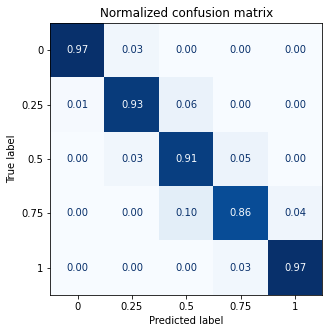

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = [0, 0.25, 0.5, 0.75, 1]


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    


plot_confusion_matrix(y_preds, y_valid, labels)

### Cross-validation

To see the a more realistic performance of the DeBERTa model on previously unseen data, we need to do cross-validations. First we load the dataset again (but shuffled). 

In [ ]:
df_cv = pd.read_csv('/content/us-patent-phrase-to-phrase-matching/train.csv').sample(frac=1, random_state=1)
df_cv['inputs'] = df_cv.context + sep + df_cv.anchor + sep + df_cv.target 
df_cv['section'] = df_cv.context.str[0]
ds = Dataset.from_pandas(df_cv).rename_column('score', 'label')

Then we create a 'get_tok_ds()' function to facilitate the generation of the tokenized dataset with respect to the model.

In [ ]:
def get_tok_ds(model):
    tokenizer = tokz(model)
    def tokz_map(x):
        return tokenizer(x['inputs'])
    tok_ds = ds.map(tokz_map, batched=True, remove_columns=rm_columns)
    return tok_ds

tok_ds_dbt = get_tok_ds(model_dbt);

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-large/snapshots/7dca0f282d1f46ecd957a64a1c6ae23dc83d7ccb/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.25.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

l

  0%|          | 0/37 [00:00<?, ?ba/s]

The sklearn offers a train_test_split method which takes a random subset of the data. But this is a poor choice for many real-world problems, since real-world datasets are often unbalanced w.r.t labels. To create a more balanced split, we use the StatifiedGroupKFold which create folds which preserve the percentage of samples for each class as much as possible given the constraint of non-overlapping groups between splits. For conveniency, we split the datasets into 4 folds.

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
n_folds = 4 
cv = StratifiedGroupKFold(n_splits=n_folds)

Then we create an array of indexes of rows, then create the folds w.r.t their scores and anchors.

In [ ]:
idxs = np.arange(len(df_cv))
scores = (df_cv.score*100).astype(int)
folds = list(cv.split(idxs, scores, df_cv.anchor))

folds

[(array([    0,     1,     3, ..., 36470, 36471, 36472]),
  array([    2,     4,     8, ..., 36459, 36460, 36467])),
 (array([    0,     1,     2, ..., 36470, 36471, 36472]),
  array([    3,    11,    12, ..., 36441, 36456, 36466])),
 (array([    0,     1,     2, ..., 36468, 36469, 36470]),
  array([    9,    13,    17, ..., 36463, 36471, 36472])),
 (array([    2,     3,     4, ..., 36467, 36471, 36472]),
  array([    0,     1,     5, ..., 36468, 36469, 36470]))]

We also need another function to help us get the datasets after splits.

In [ ]:
def get_fold(folds, fold_num, model):
  train, eval = folds[fold_num]
  tok_ds = get_tok_ds(model)
  return DatasetDict({'train': tok_ds.select(train), 
                      'eval': tok_ds.select(eval)})

Lastly, we start the CV process and save the results into a list naming "cv_pearson_dbt". As we can the Pearson scores are around 0.79-0.80. So if we only use this model without ensembling, this will likely to be our final model performance. However, the highest score on private leadership board is around 0.89, with the assistance of ensembling methods. We will also explore the use ensembling in the Combine Models section.

In [ ]:
cv_pearson_dbt = []

for i in range(n_folds):
    ds_cv = get_fold(folds, i, model_dbt)
    trainer_cv = get_trainer(ds_cv, model_dbt);
    trainer_cv.train()
    metrics = [o['eval_pearson'] 
           for o in trainer_cv.state.log_history
           if 'eval_pearson' in o]
    cv_pearson_dbt.append(metrics[-1])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-large/snapshots/7dca0f282d1f46ecd957a64a1c6ae23dc83d7ccb/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.25.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

l

  0%|          | 0/37 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-large/snapshots/7dca0f282d1f46ecd957a64a1c6ae23dc83d7ccb/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transf

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.037915,0.793547
2,No log,0.025053,0.795608
3,0.037500,0.022468,0.822329
4,0.037500,0.023525,0.819831
5,0.009400,0.022813,0.822235
6,0.009400,0.022819,0.821930


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9127
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9127
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file 

  0%|          | 0/37 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-large/snapshots/7dca0f282d1f46ecd957a64a1c6ae23dc83d7ccb/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transf

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026961,0.777736
2,No log,0.027866,0.787030
3,0.030600,0.025931,0.801162
4,0.030600,0.025331,0.799288
5,0.009600,0.025793,0.803448
6,0.009600,0.025478,0.804316


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9105
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9105
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file 

  0%|          | 0/37 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-large/snapshots/7dca0f282d1f46ecd957a64a1c6ae23dc83d7ccb/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transf

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.029348,0.777524
2,No log,0.025141,0.797862
3,0.031600,0.026774,0.799819
4,0.031600,0.024784,0.807311
5,0.009900,0.024920,0.808632
6,0.009900,0.024658,0.808328


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9122
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9122
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file 

  0%|          | 0/37 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-v3-large/snapshots/7dca0f282d1f46ecd957a64a1c6ae23dc83d7ccb/config.json
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transf

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024985,0.791998
2,No log,0.024016,0.812388
3,0.031300,0.025515,0.814768
4,0.031300,0.023572,0.822668
5,0.009500,0.022436,0.823682
6,0.009500,0.022827,0.822974


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file 

In [ ]:
pd.DataFrame(cv_pearson_dbt,
             columns = ['Pearson Score'],
             index = ['Fold_1',
                      'Fold_2',
                      'Fold_3',
                      'Fold_4',]).T

,Fold_1,Fold_2,Fold_3,Fold_4
Pearson Score,0.82193,0.804316,0.808328,0.822974


## Bert For Patent

According to the blog post "[How AI, and specifically BERT, helps the patent industry](https://cloud.google.com/blog/products/ai-machine-learning/how-ai-improves-patent-analysis)":
>Google trained a BERT (bidirectional encoder representation from transformers) model on over 100 million patent publications from the U.S. and other countries using open-source tooling. Google’s release of the BERT model (paper, blog post, and open-source code) in 2018 was an important breakthrough that leveraged transformers to outperform other leading state of the art models across major NLP benchmarks, including GLUE, MultiNLI, and SQuAD. Shortly after its release, the BERT framework and many additional transformer-based extensions gained widespread industry adoption across domains like search, chatbots, and translation.

At first, I tried to use the AutoModels from Huggingface. But some error occurred and the model didn't run as expected in the validation process. So instead, we need to customize our own model in PyTorch. We repeat the same process (as we did for DeBERTa):initiate and train the model, then get its predictions on the test dataset. To begin with, let's load all the necessary modules.

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoConfig, AutoTokenizer, get_linear_schedule_with_warmup
from itertools import chain

Then we can define a `config` class on contain all the hyper-parameters.

In [ ]:
class config:
    device = 'cuda'
    model = "anferico/bert-for-patents"
    tokenizer =  AutoTokenizer.from_pretrained(model)
    max_len = 128
    train_batch_size = 16
    valid_batch_size = 16
    epochs = 6
    lr = 2e-5

Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--anferico--bert-for-patents/snapshots/d1a25632e9c586399068a2f139d5664306b32ad8/config.json
Model config BertConfig {
  "_name_or_path": "anferico/bert-for-patents",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 39859
}



Downloading:   0%|          | 0.00/329k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--anferico--bert-for-patents/snapshots/d1a25632e9c586399068a2f139d5664306b32ad8/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--anferico--bert-for-patents/snapshots/d1a25632e9c586399068a2f139d5664306b32ad8/config.json
Model config BertConfig {
  "_name_or_path": "anferico/bert-for-patents",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidd

Then we can customize the pretrained model by only making three small differences: 
*  add a pooling_layer to merge info from one sentence into one tensor 
* add a dropout layer for regularization 
* add a classification head.

In [ ]:
class PhraseModel(nn.Module): 
    def __init__(self):
        super().__init__()
        
        model_config = AutoConfig.from_pretrained(config.model) 
        model_config.update(
            {
                "output_hidden_states": True,
                "add_pooling_layer": True,
                "num_labels": 1,
            }
        )
        self.transformer = AutoModel.from_pretrained(config.model, config=model_config)
        self.dropout = nn.Dropout(model_config.hidden_dropout_prob)
        self.output = nn.Linear(model_config.hidden_size, 1)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        transformer_out = self.transformer(input_ids, attention_mask, token_type_ids)
        output = transformer_out.pooler_output
        output = self.dropout(output)
        output = self.output(output)
        
        return output

Then we need to define the training and validation functions. Since we only have one anchor and we want to determine the similarity of the target with this only anchor, we can use the binary-cross-entropy loss function with logits.

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    train_loss = 0.0
    for data in data_loader :
        input_ids = data['input_ids'].to(device, dtype=torch.long)
        attention_mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        label = data['label'].to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(
         input_ids=input_ids,
         attention_mask=attention_mask,
         token_type_ids=token_type_ids
         )
        
        loss = nn.BCEWithLogitsLoss()(outputs, label.view(-1, 1))
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        train_loss +=loss.item()
    print(f'train BCE loss is {train_loss/len(data_loader)}')
        
def valid_fn(data_loader, model, device):
    model.eval()
    val_loss = 0.0
    final_score = []
    final_outputs = []
    with torch.no_grad():
        for data in data_loader :
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            label = data['label'].to(device, dtype=torch.float)

            outputs = model(
             input_ids=input_ids,
             attention_mask=attention_mask,
             token_type_ids=token_type_ids
             )

            val_loss += nn.BCEWithLogitsLoss()(outputs,label.view(-1, 1))
            
            label = (label.detach().cpu().numpy()).tolist()
            outputs = (torch.sigmoid(outputs).detach().cpu().numpy()).tolist()
            final_outputs.extend(outputs)
            final_score.extend(label)
            
            
    print(f"valid BCE loss : {val_loss/len(data_loader)}")
    return final_outputs, final_score     

def test_fn(data_loader, model, device):
    model.eval()

    final_outputs = []

    with torch.no_grad():
        for data in data_loader :
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            outputs = model(
             input_ids=input_ids,
             attention_mask=attention_mask,
             token_type_ids=token_type_ids
             )

            outputs = (torch.sigmoid(outputs).detach().cpu().numpy()).tolist()
            final_outputs.extend(outputs)

    return final_outputs

Next, we need to format the data to feed into the model. Since this time we need to use the `encode_plus` function to return the additional `token_type_ids` information, we also need to create a new tokenizer function for it.

In [ ]:
from datasets import Dataset
ds = Dataset.from_pandas(df).rename_column('score', 'label')
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'section', 'text', 'inputs'],
    num_rows: 36473
})

In [ ]:
tokz_bfp = config.tokenizer

def tokz_map_bfp(x):
  return tokz_bfp.encode_plus(x['text'], 
                              x['target'], 
                              padding="max_length",
                              max_length=128, 
                              truncation=True,)

After the tokenization of the dataset, we need to set the format as pytorch and use the default dataloader to create several dataloaders for training, evaluation, and testing purposes.

In [ ]:
tok_ds_bfp = ds.map(tokz_map_bfp, remove_columns=rm_columns)
tok_ds_bfp.set_format(type='torch')

  0%|          | 0/36473 [00:00<?, ?ex/s]

In [ ]:
dds_bfp = DatasetDict({'train':tok_ds_bfp.select(trn_idxs), 
                        'valid': tok_ds_bfp.select(val_idxs),
                        'test': tok_ds_bfp.select(test_idxs)})

In [ ]:
train_loader = DataLoader(dds_bfp['train'], batch_size = config.train_batch_size, shuffle=True)
valid_loader = DataLoader(dds_bfp['valid'], batch_size = config.valid_batch_size, shuffle=False)
test_loader = DataLoader(dds_bfp['test'], batch_size = config.valid_batch_size, shuffle=False)

Then we can initiate the model and cast it to `CUDA`.

In [ ]:
model = PhraseModel()
model.to(config.device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--anferico--bert-for-patents/snapshots/d1a25632e9c586399068a2f139d5664306b32ad8/config.json
Model config BertConfig {
  "_name_or_path": "anferico/bert-for-patents",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 39859
}



Downloading:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--anferico--bert-for-patents/snapshots/d1a25632e9c586399068a2f139d5664306b32ad8/pytorch_model.bin
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSeq

PhraseModel(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(39859, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, eleme

We use the AdamW function as the optimizer. According to the post [Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/):
> Adam realizes the benefits of both AdaGrad and RMSProp. Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance). Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.weight"]
optimizer_parameters = [
  {
      "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      "weight_decay": 0.01,
  },
  {
      "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      "weight_decay": 0.0,
  }
]

In [ ]:
optimizer = torch.optim.AdamW(optimizer_parameters, lr=config.lr)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=num_train_steps,)

num_train_steps = int(len(dds_bfp['train']) / config.train_batch_size * config.epochs)

Finally we can train the model and see its performances on validation set. Similar with the performance of DeBERTa model, the Pearson correlation is around 82% ish.

In [ ]:
for epoch in range(config.epochs):
  train_fn(train_loader, model, optimizer, config.device, scheduler)
  outputs, labels = valid_fn(valid_loader, model, config.device)

  pearson_score = np.corrcoef(list(chain.from_iterable(outputs)), labels)[0][1]

  print(f"Epoch {epoch}: pearson Score = {pearson_score}\n")

  torch.save(model.state_dict(), f'model-epoch{epoch}.pth') 

train BCE loss is 0.5646241080490498
valid BCE loss : 0.5535075664520264
Epoch 0: pearson Score = 0.8006024384282224

train BCE loss is 0.5265992130388556
valid BCE loss : 0.5471455454826355
Epoch 1: pearson Score = 0.8162311165686937

train BCE loss is 0.5094882460650211
valid BCE loss : 0.5545110106468201
Epoch 2: pearson Score = 0.8130503754830288

train BCE loss is 0.49819372147061647
valid BCE loss : 0.555500864982605
Epoch 3: pearson Score = 0.8193747515614255

train BCE loss is 0.4903223394584767
valid BCE loss : 0.5647590160369873
Epoch 4: pearson Score = 0.8176588200109112

train BCE loss is 0.48581084594295215
valid BCE loss : 0.5644716620445251
Epoch 5: pearson Score = 0.8175097842292652



# Combine Models

### DeBERTa Predictions

Since we saved the predictions right after the training process, we can just load the results back for evaluation purpose.

In [ ]:
with open("predictions_dbt", "rb") as file:   # Unpickling
  predictions_dbt = pickle.load(file)
  
predictions_dbt[:5]

[0.0, 0.0, 0.6103515625, 0.139404296875, 0.58251953125]

### Bert For Patent Predictions

For BFP, first we need to load from saved model and then use it for predictions.

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Completed Projects/Trained_Models/model-epoch3.pth'

In [ ]:
model = PhraseModel()
model.load_state_dict(torch.load(model_path))
model.to(config.device)
model.eval()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--anferico--bert-for-patents/snapshots/d1a25632e9c586399068a2f139d5664306b32ad8/config.json
Model config BertConfig {
  "_name_or_path": "anferico/bert-for-patents",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 39859
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--anferico--bert-for-patents/snapshots/d1a25632e9c586399068a2f139d5664306b32ad8/pytorch_model.bin

PhraseModel(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(39859, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, eleme

Let's use our model to make predictions on the test dataset. Since the above results are list of lists. We need to chain them together as a 1-dimensional list.

In [ ]:
outputs = test_fn(test_loader, model, config.device)
predictions_bfp = list(chain.from_iterable(outputs)) 
predictions_bfp[:5]

[0.0004797093279194087,
 0.00029764758073724806,
 0.5656285881996155,
 0.10181351006031036,
 0.5108011960983276]

Since our two models have approximately equal performances on the validation set, we can combine the two predictions using a simple ensemble technique: taking the average of them.

In [ ]:
ensemble_predictions = [(a+b)/2 for a, b in zip(predictions_dbt, predictions_bfp)]
ensemble_predictions[:5]

[0.00023985466395970434,
 0.00014882379036862403,
 0.5879900753498077,
 0.12060890346765518,
 0.5466603636741638]

Another idea that might be helpful is rounding! Since we know the labels will only be on the quarters: 0.0, 0.25, 0.5, 0.75, 1.0, we can try to round the results into its nearest quarter to see if this additional information can help or not.

In [ ]:
def round_predictions(x):
  output = []
  for _ in x:
    output.append(round_to_quarter(_))
  return output

rounded_predictions_dbt = round_predictions(predictions_dbt)
rounded_predictions_bfp = round_predictions(predictions_bfp)
rounded_predictions_ensemble = round_predictions(ensemble_predictions)

## Final words

At the end, we calculate all the correlations and put it in a dataframe.

In [ ]:
labels = dds_dbt['test']['label']

results = np.array([labels,
                 predictions_dbt, 
                 rounded_predictions_dbt, 
                 predictions_bfp, 
                 rounded_predictions_bfp,
                 ensemble_predictions,
                 rounded_predictions_ensemble])

pearson_corrs = np.corrcoef(results)[0]

pd.DataFrame(pearson_corrs, 
             columns = ['Pearson Score'],
             index = ['Labels',
                      'DeBERTa',
                      'DeBERTa_Rd',
                      'BERT for Patent',
                      'BFP_Rd',
                      'Ensemble',
                      'ESB_Rd',]).T

,Labels,DeBERTa,DeBERTa_Rd,BERT for Patent,BFP_Rd,Ensemble,ESB_Rd
Pearson Score,1.0,0.771167,0.744051,0.753628,0.715623,0.782735,0.75192


We can see rounding to the nearest quarter has actually decreased the prediction accuracy. On the other hand, at a 78.27% score, the ensemble method attains the best performance! So we can safely say that ensemble techniques do improve prediction accuracy.

# Reference
[1] He, Pengcheng, et al. "Deberta: Decoding-enhanced bert with disentangled attention." arXiv preprint arXiv:2006.03654 (2020).

[2] Resources, MPEP. “MPEP.” United States Patent and Trademark Office, https://www.uspto.gov/web/offices/pac/mpep/s905.html. 

[3] Bibhabasumohapatra. “Train US Patent - Part 1 Simple Pytorch.” Kaggle, Kaggle, 1 Apr. 2022, https://www.kaggle.com/code/bibhabasumohapatra/train-us-patent-part-1-simple-pytorch. 